# Controlled Neural Differential Equations - Time Series Classification
This notebook is based on the examples from the `torchcde` package by Kidger and Morrill which can be found at
[https://github.com/patrick-kidger/torchcde](https://github.com/patrick-kidger/torchcde).
Further information about the techniques described in this notebook can be found

> Kidger, P., Morrill, J., Foster, J. and Lyons, T., 2020.
 Neural controlled differential equations for irregular time series.
 arXiv preprint arXiv:[2005.08926](https://arxiv.org/abs/2005.08926).

> Morrill, J., Kidger, P., Yang, L. and Lyons, T., 2021.
 Neural Controlled Differential Equations for Online Prediction Tasks.
 arXiv preprint arXiv:[2106.11028](https://arxiv.org/abs/2106.11028).

> Kidger, P., Foster, J., Li, X., Oberhauser, H. and Lyons, T., 2021.
 Neural sdes as infinite-dimensional gans.
 arXiv preprint arXiv:[2102.03657](https://arxiv.org/abs/2102.03657).

The

## Set up the notebook

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Cloning https://github.com/patrick-kidger/torchcde.git (to revision 4620b4b8bfb08416f4871c9e76510b69439ee916) to /tmp/pip-install-y33cw0nj/torchcde_c55209073b2243b28220a5e9bde64024
  Running command git clone -q https://github.com/patrick-kidger/torchcde.git /tmp/pip-install-y33cw0nj/torchcde_c55209073b2243b28220a5e9bde64024
  Running command git rev-parse -q --verify 'sha^4620b4b8bfb08416f4871c9e76510b69439ee916'
  Running command git fetch -q https://github.com/patrick-kidger/torchcde.git 4620b4b8bfb08416f4871c9e76510b69439ee916
  Cloning https://github.com/google-research/torchsde.git to /tmp/pip-install-y33cw0nj/torchsde_9e2c2cbb9e4d429a9459ac51d0967926
  Running command git clone -q https://github.com/google-research/torchsde.git /tmp/pip-install-y33cw0nj/torchsde_9e2c2cbb9e4d429a9459ac51d0967926
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done


## Import the necessary packages

In [2]:
import math
import numpy as np
import torch
import torchcde
import matplotlib.pyplot as plt


A CDE model looks like

$$z_t = z_0 + \int_0^t f_\theta(z_s) dX_s$$

Where $X$ is your data and $f_\theta$ is a neural network. So the first thing we need to do is define such an $f_\theta$.
That's what this CDEFunc class does.
Here we've built a small single-hidden-layer neural network, whose hidden layer is of width 128.

In [3]:
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = torch.nn.Linear(hidden_channels, 128)
        self.linear2 = torch.nn.Linear(128, input_channels * hidden_channels)

    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

Next, we need to package CDEFunc up into a model that computes the integral.

In [4]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, interpolation="cubic"):
        super(NeuralCDE, self).__init__()

        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, output_channels)
        self.interpolation = interpolation

    def forward(self, coeffs):
        if self.interpolation == 'cubic':
            X = torchcde.NaturalCubicSpline(coeffs)
        elif self.interpolation == 'linear':
            X = torchcde.LinearInterpolation(coeffs)
        else:
            raise ValueError("Only 'linear' and 'cubic' interpolation methods are implemented.")

        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval)

        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
        pred_y = self.readout(z_T)
        return pred_y

Now we need some data.
Here we have a simple example which generates some spirals, some going clockwise, some going anticlockwise.

In [5]:
def get_data(num_timepoints=100):
    t = torch.linspace(0., 4 * math.pi, num_timepoints)

    start = torch.rand(128) * 2 * math.pi
    x_pos = torch.cos(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos[:64] *= -1
    y_pos = torch.sin(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos += 0.01 * torch.randn_like(x_pos)
    y_pos += 0.01 * torch.randn_like(y_pos)
    ######################
    # Easy to forget gotcha: time should be included as a channel; Neural CDEs need to be explicitly told the
    # rate at which time passes. Here, we have a regularly sampled dataset, so appending time is pretty simple.
    ######################
    X = torch.stack([t.unsqueeze(0).repeat(128, 1), x_pos, y_pos], dim=2)
    y = torch.zeros(128)
    y[:64] = 1

    perm = torch.randperm(128)
    X = X[perm]
    y = y[perm]

    ######################
    # X is a tensor of observations, of shape (batch=128, sequence=100, channels=3)
    # y is a tensor of labels, of shape (batch=128,), either 0 or 1 corresponding to anticlockwise or clockwise respectively.
    ######################
    return X, y

In [6]:
NUM_EPOCHS = 30

In [7]:
train_X, train_y = get_data()

input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
output_channels=1 because we're doing binary classification.

In [8]:
model = NeuralCDE(input_channels=3, hidden_channels=8, output_channels=1)
optimizer = torch.optim.Adam(model.parameters())

Now we turn our dataset into a continuous path. We do this here via natural cubic spline interpolation.
The resulting `train_coeffs` is a tensor describing the path.
For most problems, it's probably easiest to save this tensor and treat it as the dataset.

In [9]:
from torch.utils.data import TensorDataset
train_coeffs = torchcde.natural_cubic_coeffs(train_X)
train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

In [10]:
for epoch in range(NUM_EPOCHS):
    for batch in train_dataloader:
        batch_coeffs, batch_y = batch
        pred_y = model(batch_coeffs).squeeze(-1)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_y, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch: {:2d}   Training loss: {}'.format(epoch, loss.item()))


Epoch:  0   Training loss: 0.591900110244751
Epoch:  1   Training loss: 0.5691879987716675
Epoch:  2   Training loss: 0.4391317367553711
Epoch:  3   Training loss: 0.3183804154396057
Epoch:  4   Training loss: 0.12590204179286957
Epoch:  5   Training loss: 0.05028655752539635
Epoch:  6   Training loss: 0.019360331818461418
Epoch:  7   Training loss: 0.009352361783385277
Epoch:  8   Training loss: 0.005007205996662378
Epoch:  9   Training loss: 0.0029659783467650414
Epoch: 10   Training loss: 0.0019759959541261196
Epoch: 11   Training loss: 0.0014610663056373596
Epoch: 12   Training loss: 0.001173303578980267
Epoch: 13   Training loss: 0.0010014527942985296
Epoch: 14   Training loss: 0.000883798929862678
Epoch: 15   Training loss: 0.0008047460578382015
Epoch: 16   Training loss: 0.000749182072468102
Epoch: 17   Training loss: 0.0007003145292401314
Epoch: 18   Training loss: 0.0006656608311459422
Epoch: 19   Training loss: 0.0006364437285810709
Epoch: 20   Training loss: 0.00061014672974

In [11]:
test_X, test_y = get_data()


test_coeffs = torchcde.natural_cubic_coeffs(test_X)
pred_y = model(test_coeffs).squeeze(-1)
binary_prediction = (torch.sigmoid(pred_y) > 0.5).to(test_y.dtype)
prediction_matches = (binary_prediction == test_y).to(test_y.dtype)
proportion_correct = prediction_matches.sum() / test_y.size(0)
print('Test Accuracy: {}'.format(proportion_correct))

Test Accuracy: 1.0


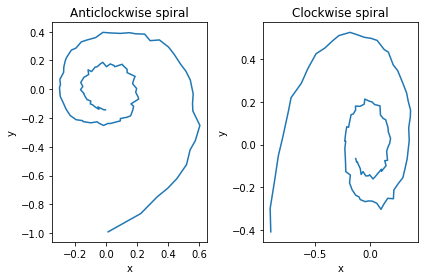

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)
idx, = np.where(train_y == 0)
ax1.plot(train_X[idx[0], :, 1], train_X[idx[0], :, 2])
ax1.set_title("Anticlockwise spiral")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

idx, = np.where(train_y == 1)
ax2.plot(train_X[idx[0], :, 1], train_X[idx[0], :, 2])
ax2.set_title("Clockwise spiral")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
plt.show()
